Text(0, 0.5, 'Cycle life')

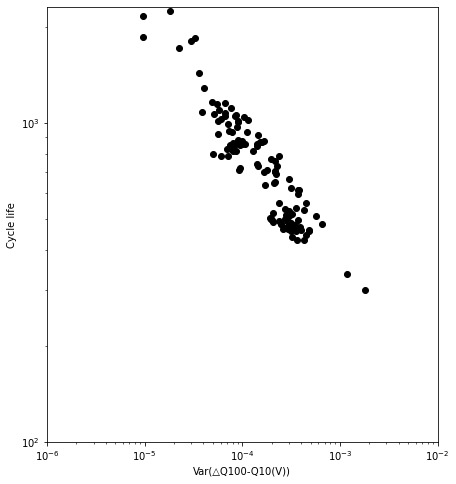

In [1]:
import h5py
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import matplotlib.cm as cm
from scipy.signal import savgol_filter
from scipy import stats

batch1 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch1.pkl', 'rb'))
#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

numBat1 = len(batch1.keys())

batch2 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch2.pkl','rb'))
# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]

del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

numBat2 = len(batch2.keys())

batch3 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch3.pkl','rb'))
# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c38']
del batch3['b3c39']

numBat3 = len(batch3.keys())
numBat = numBat1 + numBat2 + numBat3
bat_dict = {**batch1, **batch2, **batch3}

X=[]
Y=[]

for i,j in enumerate(bat_dict.keys()):
    if j=='b2c1':
        continue
    if j=='b3c16':
        continue
    if j=='b3c17':
        continue
    if j=='b3c42':
        continue
    if j=='b3c43':
        continue
    Qdlin10,Qdlin100=bat_dict[j]['cycles']['9']['Qdlin'],bat_dict[j]['cycles']['99']['Qdlin']
    diff=diff=Qdlin100-Qdlin10
    var,cycle=np.var(diff),bat_dict[j]['cycle_life'].tolist()
    X.append(var)
    Y.append(cycle[0][0])
    
plt.figure(figsize=(7,8))
plt.scatter(X,Y,color='black')
plt.xscale('log')
plt.yscale('log')
plt.axis([10**(-6),10**(-2),100,2300])
plt.xlabel('Var(△Q100-Q10(V))')
plt.ylabel('Cycle life')

In [2]:
test_ind = np.hstack((np.arange(0,(numBat1+numBat2),2),83))
train_ind = np.arange(1,(numBat1+numBat2-1),2)
secondary_test_ind = np.arange(numBat-numBat3,numBat);

In [3]:
np.random.seed(42)
threshold = 550

In [4]:
imax=50
jmax=50

def i_j_make():
    i_=[]
    j_=[]
    for i in range(2,imax+1): # 
        for j in range(1,jmax+1): # j
            if i<=j:
                continue
            i_.append(i)
            j_.append(j)
    return i_,j_

In [5]:
i_, j_ =i_j_make()

In [6]:
test_data=[]
train_data=[]

test_label=[]
train_label=[]

sec_data=[]
sec_label=[]
for i,j in enumerate(bat_dict.keys()):
    if j=='b2c1':
        continue
    if j=='b3c16':
        continue
    if j=='b3c17':
        continue
    if j=='b3c42':
        continue
    if j=='b3c43':
        continue
    if i in test_ind :
        test_data.append(j)
        cycle_test=bat_dict[j]['cycle_life'].tolist()
        if cycle_test[0][0]>=threshold:
            test_label.append(1)
        else:
            test_label.append(0)
        
    if i in train_ind :
        train_data.append(j)
        cycle_train=bat_dict[j]['cycle_life'].tolist()
        if cycle_train[0][0]>=threshold:
            train_label.append(1)
        else:
            train_label.append(0)
            
            
    if i in secondary_test_ind:
        sec_data.append(j)
        cycle_sec=bat_dict[j]['cycle_life'].tolist()
        if cycle_sec[0][0]>=threshold:
            sec_label.append(1)
        else:
            sec_label.append(0)

In [7]:
test_data=np.array(test_data)
train_data=np.array(train_data)
test_label=np.array(test_label)
train_label=np.array(train_label)
sec_label=np.array(sec_label)
sec_data=np.array(sec_data)

In [8]:
from sklearn.linear_model import LinearRegression
from scipy import integrate
from scipy.stats import skew
from scipy.stats import kurtosis
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
def Averagetime(i,k):
    if i < 5:
        sumtime=0
        for j in range(i):
            time=bat_dict[k]['summary']['chargetime'][j+1]
            sumtime+=time
        ACT=sumtime/i
    else:
        t1=bat_dict[k]['summary']['chargetime'][1]
        t2=bat_dict[k]['summary']['chargetime'][2]
        t3=bat_dict[k]['summary']['chargetime'][3]
        t4=bat_dict[k]['summary']['chargetime'][4]
        t5=bat_dict[k]['summary']['chargetime'][5]
        ACT=(t1+t2+t3+t4+t5)/5
    return ACT

def searchmaxQ_cycle2(k):
    x=bat_dict[k]['summary']['QD']
    cycle2=bat_dict[k]['summary']['QD'][2]
    while True:
        if np.max(x)>1.2:
            delete=np.where(np.max(x)==x)[0][0]
            x=np.delete(x, delete)
        if np.max(x)<=1.2:
            break
    return np.max(x)-cycle2


def make_standard_data(i,j):
    # 1. min

    min_=np.array([])
    min_test_=np.array([])
    min_sec_=np.array([])
    for k in train_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        min_=np.hstack([min_,np.min(diff)])
    for k in test_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        min_test_=np.hstack([min_test_,np.min(diff)])
    for k in sec_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        min_sec_=np.hstack([min_sec_,np.min(diff)])

    # 2. mean
    mean_=np.array([])
    mean_test_=np.array([])
    mean_sec_=np.array([])
    for k in train_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        mean_=np.hstack([mean_,np.mean(diff)])
    for k in test_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        mean_test_=np.hstack([mean_test_,np.mean(diff)])
    for k in sec_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        mean_sec_=np.hstack([mean_sec_,np.mean(diff)])       

    # 3. var
    var_=np.array([])
    var_test_=np.array([])
    var_sec_=np.array([])
    for k in train_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        var_=np.hstack([var_,np.var(diff)])
    for k in test_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        var_test_=np.hstack([var_test_,np.var(diff)])
    for k in sec_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        var_sec_=np.hstack([var_sec_,np.var(diff)])

    # 4. Skewness
    skew_=np.array([])
    skew_test_=np.array([])
    skew_sec_=np.array([])
    for k in train_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        skew_=np.hstack([skew_,skew(diff)])
    for k in test_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        skew_test_=np.hstack([skew_test_,skew(diff)])
    for k in sec_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        skew_sec_=np.hstack([skew_sec_,skew(diff)])

    # 5. Kurtosis
    kurt_=np.array([])
    kurt_test_=np.array([])
    kurt_sec_=np.array([])
    for k in train_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        kurt_=np.hstack([kurt_,kurtosis(diff,fisher=True)])
    for k in test_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        kurt_test_=np.hstack([kurt_test_,kurtosis(diff,fisher=True)])
    for k in sec_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        kurt_sec_=np.hstack([kurt_sec_,kurtosis(diff,fisher=True)])

    # 6. Value at 2V
    Value2V_=np.array([])
    Value2V_test_=np.array([])
    Value2V_sec_=np.array([])
    for k in train_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        Value2V_=np.hstack([Value2V_,diff[-1]])
    for k in test_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        Value2V_test_=np.hstack([Value2V_test_,diff[-1]])
    for k in sec_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        Value2V_sec_=np.hstack([Value2V_sec_,diff[-1]])


    # 7. j to i slope, 8. intercept
    slope_=np.array([])
    slope_test_=np.array([])
    slope_sec_=np.array([])

    intercept_=np.array([])
    intercept_test_=np.array([])
    intercept_sec_=np.array([])

    Train=np.array(range(j,i+1)).reshape(-1,1)
    for k in train_data:
        QD_data=bat_dict[k]['summary']['QD'][j:i+1]
        label=np.array(QD_data).ravel()

        reg = LinearRegression()
        reg.fit(Train,label)

        slope_=np.hstack([slope_,reg.coef_])
        intercept_=np.hstack([intercept_,reg.intercept_])

    for k in test_data:
        QD_data=bat_dict[k]['summary']['QD'][j:i+1]
        label=np.array(QD_data).ravel()

        reg = LinearRegression()
        reg.fit(Train,label)

        slope_test_=np.hstack([slope_test_,reg.coef_])
        intercept_test_=np.hstack([intercept_test_,reg.intercept_])
    for k in sec_data:
        QD_data=bat_dict[k]['summary']['QD'][j:i+1]
        label=np.array(QD_data).ravel()

        reg = LinearRegression()
        reg.fit(Train,label)

        slope_sec_=np.hstack([slope_sec_,reg.coef_])
        intercept_sec_=np.hstack([intercept_sec_,reg.intercept_])

    # 9. Discharge Capacity, Cycle2
    cycle2_=np.array([])
    cycle2_test_=np.array([])
    cycle2_sec_=np.array([])
    for k in train_data:
        Cycle2=bat_dict[k]['summary']['QD'][2]
        cycle2_=np.hstack([cycle2_,Cycle2])
    for k in test_data:
        Cycle2=bat_dict[k]['summary']['QD'][2]
        cycle2_test_=np.hstack([cycle2_test_,Cycle2])
    for k in sec_data:
        Cycle2=bat_dict[k]['summary']['QD'][2]
        cycle2_sec_=np.hstack([cycle2_sec_,Cycle2])

    # 10. Difference between max discharge capacity and cycle 2
    cyclemax_2_=np.array([])
    cyclemax_2_test_=np.array([])
    cyclemax_2_sec_=np.array([])
    for k in train_data:
        cyclemax_2=searchmaxQ_cycle2(k)
        cyclemax_2_=np.hstack([cyclemax_2_,cyclemax_2])
    for k in test_data:
        cyclemax_2=searchmaxQ_cycle2(k)
        cyclemax_2_test_=np.hstack([cyclemax_2_test_,cyclemax_2])
    for k in sec_data:
        cyclemax_2=searchmaxQ_cycle2(k)
        cyclemax_2_sec_=np.hstack([cyclemax_2_sec_,cyclemax_2])

    # 11. Discharge capacity, cycle i (cycle i에 따른 값변경)
    cycle_i_=np.array([])
    cycle_i_test_=np.array([])
    cycle_i_sec_=np.array([])
    for k in train_data:
        Cycle100=bat_dict[k]['summary']['QD'][i]
        cycle_i_=np.hstack([cycle_i_,Cycle100])
    for k in test_data:
        Cycle100=bat_dict[k]['summary']['QD'][i]
        cycle_i_test_=np.hstack([cycle_i_test_,Cycle100])
    for k in sec_data:
        Cycle100=bat_dict[k]['summary']['QD'][i]
        cycle_i_sec_=np.hstack([cycle_i_sec_,Cycle100])        

    # 12. Average charge time, first 5 cycles -> 5 cycle이 안되는 data는 최대 cycle
    Average_=np.array([])
    Average_test_=np.array([])
    Average_sec_=np.array([])

    for k in train_data:
        Average_time=Averagetime(i,k)
        Average_=np.hstack([Average_,Average_time])
    for k in test_data:
        Average_time=Averagetime(i,k)
        Average_test_=np.hstack([Average_test_,Average_time])
    for k in sec_data:
        Average_time=Averagetime(i,k)
        Average_sec_=np.hstack([Average_sec_,Average_time])

    # 13. Maximum temperature, cycles 2 to i 
    Max_cycleT_=np.array([])
    Max_cycleT_test_=np.array([])
    Max_cycleT_sec_=np.array([])
    for k in train_data:
        maxt=[]
        for k_ in range(2,i+1):
            c=np.max(bat_dict[k]['cycles']['{}'.format(k_)]['T'])
            maxt.append(c)  
        max_cycle_T=np.max(maxt)
        Max_cycleT_=np.hstack([Max_cycleT_,max_cycle_T])
    for k in test_data:
        maxt=[]
        for k_ in range(2,i+1):
            c=np.max(bat_dict[k]['cycles']['{}'.format(k_)]['T'])
            maxt.append(c)  
        max_cycle_T=np.max(maxt)
        Max_cycleT_test_=np.hstack([Max_cycleT_test_,max_cycle_T])
    for k in sec_data:
        maxt=[]
        for k_ in range(2,i+1):
            c=np.max(bat_dict[k]['cycles']['{}'.format(k_)]['T'])
            maxt.append(c)  
        max_cycle_T=np.max(maxt)
        Max_cycleT_sec_=np.hstack([Max_cycleT_sec_,max_cycle_T])   


    # 14. Minimum temperature, cycles 2 to 100 
    Min_cycleT_=np.array([])
    Min_cycleT_test_=np.array([])
    Min_cycleT_sec_=np.array([])
    for k in train_data:
        mint=[]
        for k_ in range(2,i+1):
            c=np.min(bat_dict[k]['cycles']['{}'.format(k_)]['T'])
            mint.append(c)  
        min_cycle_T=np.min(mint)
        Min_cycleT_=np.hstack([Min_cycleT_,min_cycle_T])
    for k in test_data:
        mint=[]
        for k_ in range(2,i+1):
            c=np.min(bat_dict[k]['cycles']['{}'.format(k_)]['T'])
            mint.append(c)  
        min_cycle_T=np.min(mint)
        Min_cycleT_test_=np.hstack([Min_cycleT_test_,min_cycle_T])
    for k in sec_data:
        mint=[]
        for k_ in range(2,i+1):
            c=np.min(bat_dict[k]['cycles']['{}'.format(k_)]['T'])
            mint.append(c)  
        min_cycle_T=np.min(mint)
        Min_cycleT_sec_=np.hstack([Min_cycleT_sec_,min_cycle_T])  

    #15. Integral of temperature over time, cycles 2 to i
    integralT_=np.array([])
    integralT_test_=np.array([])
    integralT_sec_=np.array([])

    for k in train_data:
        integral=[]
        for k_ in range(2,i+1):
            y=bat_dict[k]['cycles']['{}'.format(k_)]['T'].tolist()
            x=bat_dict[k]['cycles']['{}'.format(k_)]['t'].tolist()        
            integral.append(integrate.trapz(y,x))
        intg=sum(integral)
        integralT_=np.hstack([integralT_,intg])



    for k in test_data:
        integral=[]
        for k_ in range(2,i+1):
            y=bat_dict[k]['cycles']['{}'.format(k_)]['T'].tolist()
            x=bat_dict[k]['cycles']['{}'.format(k_)]['t'].tolist()        
            integral.append(integrate.trapz(y,x))
        intg=sum(integral)
        integralT_test_=np.hstack([integralT_test_,intg])



    for k in sec_data:
        integral=[]
        for k_ in range(2,i+1):
            y=bat_dict[k]['cycles']['{}'.format(k_)]['T'].tolist()
            x=bat_dict[k]['cycles']['{}'.format(k_)]['t'].tolist()        
            integral.append(integrate.trapz(y,x))
        intg=sum(integral)
        integralT_sec_=np.hstack([integralT_sec_,intg])

    # 16. internal resistance, cycle2 
    cycle2IR_=np.array([])
    cycle2IR_test_=np.array([])
    cycle2IR_sec_=np.array([])
    for k in train_data:
        Cycle2=bat_dict[k]['summary']['IR'][2]
        cycle2IR_=np.hstack([cycle2IR_,Cycle2])
    for k in test_data:
        Cycle2=bat_dict[k]['summary']['IR'][2]
        cycle2IR_test_=np.hstack([cycle2IR_test_,Cycle2])
    for k in sec_data:
        Cycle2=bat_dict[k]['summary']['IR'][2]
        cycle2IR_sec_=np.hstack([cycle2IR_sec_,Cycle2])  

    # 17, Minimum internal resistance, cycles 2  to i      
    minR_=np.array([])
    minR_test_=np.array([])
    minR_sec_=np.array([])

    for k in train_data:
        minIR=[]
        for k_ in range(2,i+1):
            IR=bat_dict[k]['summary']['IR'][k_]
            if IR==0:
                continue
            minIR.append(IR)
        minIR_=min(minIR)
        minR_=np.hstack([minR_,minIR_])
    for k in test_data:
        minIR=[]
        for k_ in range(2,i+1):
            IR=bat_dict[k]['summary']['IR'][k_]
            if IR==0:
                continue
            minIR.append(IR)
        minIR_=min(minIR)
        minR_test_=np.hstack([minR_test_,minIR_])
    for k in sec_data:
        minIR=[]
        for k_ in range(2,i+1):
            IR=bat_dict[k]['summary']['IR'][k_]
            if IR==0:
                continue
            minIR.append(IR)
        minIR_=min(minIR)
        minR_sec_=np.hstack([minR_sec_,minIR_])   


    # 18  Internal resistance, difference between cycle i and cycle 1    
    IRi_2_=np.array([])
    IRi_2_test_=np.array([])
    IRi_2_sec_=np.array([])

    for k in train_data:
        IR2=bat_dict[k]['summary']['IR'][1]
        IR_i=bat_dict[k]['summary']['IR'][i]
        IRi_2=IR_i-IR2
        IRi_2_=np.hstack([IRi_2_,IRi_2])
    for k in test_data:
        IR2=bat_dict[k]['summary']['IR'][1]
        IR_i=bat_dict[k]['summary']['IR'][i]
        IRi_2=IR_i-IR2
        IRi_2_test_=np.hstack([IRi_2_test_,IRi_2])
    for k in sec_data:
        IR2=bat_dict[k]['summary']['IR'][1]
        IR_i=bat_dict[k]['summary']['IR'][i]
        IRi_2=IR_i-IR2
        IRi_2_sec_=np.hstack([IRi_2_sec_,IRi_2])


    #데이터 특성별 정규화 과정 (18개의 feature를 합친 후 각 열을 정규화)
    # 1. Train, Test, Sec
    # min, mean, var, skew, kurt, Value 2V 는 log(abs)를 한다.
    Train_data=np.hstack([np.log(np.abs(min_)).reshape(-1,1),np.log(np.abs(mean_)).reshape(-1,1),np.log(np.abs(var_)).reshape(-1,1),
                         np.log(np.abs(skew_)).reshape(-1,1),np.log(np.abs(kurt_)).reshape(-1,1),np.log(np.abs(Value2V_)).reshape(-1,1),
                         slope_.reshape(-1,1),intercept_.reshape(-1,1),cycle2_.reshape(-1,1),cyclemax_2_.reshape(-1,1),
                         cycle_i_.reshape(-1,1),Average_.reshape(-1,1),Max_cycleT_.reshape(-1,1),Min_cycleT_.reshape(-1,1),
                         integralT_.reshape(-1,1),cycle2IR_.reshape(-1,1),minR_.reshape(-1,1),IRi_2_.reshape(-1,1)])
    Test_data=np.hstack([np.log(np.abs(min_test_)).reshape(-1,1),np.log(np.abs(mean_test_)).reshape(-1,1),np.log(np.abs(var_test_)).reshape(-1,1),
                         np.log(np.abs(skew_test_)).reshape(-1,1),np.log(np.abs(kurt_test_)).reshape(-1,1),np.log(np.abs(Value2V_test_)).reshape(-1,1),
                         slope_test_.reshape(-1,1),intercept_test_.reshape(-1,1),cycle2_test_.reshape(-1,1),cyclemax_2_test_.reshape(-1,1),
                         cycle_i_test_.reshape(-1,1),Average_test_.reshape(-1,1),Max_cycleT_test_.reshape(-1,1),Min_cycleT_test_.reshape(-1,1),
                         integralT_test_.reshape(-1,1),cycle2IR_test_.reshape(-1,1),minR_test_.reshape(-1,1),IRi_2_test_.reshape(-1,1)])    
    Sec_data=np.hstack([np.log(np.abs(min_sec_)).reshape(-1,1),np.log(np.abs(mean_sec_)).reshape(-1,1),np.log(np.abs(var_sec_)).reshape(-1,1),
                         np.log(np.abs(skew_sec_)).reshape(-1,1),np.log(np.abs(kurt_sec_)).reshape(-1,1),np.log(np.abs(Value2V_sec_)).reshape(-1,1),
                         slope_sec_.reshape(-1,1),intercept_sec_.reshape(-1,1),cycle2_sec_.reshape(-1,1),cyclemax_2_sec_.reshape(-1,1),
                         cycle_i_sec_.reshape(-1,1),Average_sec_.reshape(-1,1),Max_cycleT_sec_.reshape(-1,1),Min_cycleT_sec_.reshape(-1,1),
                         integralT_sec_.reshape(-1,1),cycle2IR_sec_.reshape(-1,1),minR_sec_.reshape(-1,1),IRi_2_sec_.reshape(-1,1)])  
    Train_data_standard=(Train_data-np.mean(Train_data,axis=0))/np.std(Train_data,axis=0)
    Test_data_standard=(Test_data-np.mean(Train_data,axis=0))/np.std(Train_data,axis=0)
    Sec_data_standard=(Sec_data-np.mean(Train_data,axis=0))/np.std(Train_data,axis=0)
    return Train_data_standard, Test_data_standard, Sec_data_standard

In [11]:
def logistic_auc(Train_data_standard,train_label,Test_data_standard,test_label,Sec_data_standard,sec_label):
    
    Log_reg = LogisticRegressionCV(cv=4,penalty='l1',solver='liblinear')
    Log_reg.fit(Train_data_standard,train_label)
    AUC_train=roc_auc_score(train_label, Log_reg.decision_function(Train_data_standard))
    AUC_test=roc_auc_score(test_label, Log_reg.decision_function(Test_data_standard))
    
    coef_info=Log_reg.coef_
    
    pred_train=Log_reg.predict(Train_data_standard)
    at=accuracy_score(train_label,pred_train)
    pred_test=Log_reg.predict(Test_data_standard)
    apt=accuracy_score(test_label,pred_test)
    pred_sec=Log_reg.predict(Sec_data_standard)
    ast=accuracy_score(sec_label,pred_sec)
    
    conf_train=confusion_matrix(train_label,pred_train)
    conf_test=confusion_matrix(test_label,pred_test)
    conf_sec=confusion_matrix(sec_label,pred_sec)
    
    return AUC_train, AUC_test,coef_info,conf_train,conf_test,conf_sec, at , apt, ast

In [13]:
Train_data_standard, Test_data_standard, Sec_data_standard=make_standard_data(40,39)
AUC_train, AUC_test,coef_info,conf_train,conf_test,conf_sec, at , apt, ast= logistic_auc(Train_data_standard,train_label,Test_data_standard,test_label,Sec_data_standard,sec_label)
AUC_train, AUC_test,coef_info,conf_train,conf_test,conf_sec, at , apt, ast

(1.0,
 0.9818181818181817,
 array([[ 0.        ,  0.        , -1.76495802,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.17699958,  0.        ,  0.        ,  0.        ,
         -0.54928582,  0.        ,  0.39507247]]),
 array([[21,  0],
        [ 0, 20]], dtype=int64),
 array([[18,  2],
        [ 2, 20]], dtype=int64),
 array([[ 0,  1],
        [ 0, 35]], dtype=int64),
 1.0,
 0.9047619047619048,
 0.9722222222222222)

In [14]:
Train_data_standard, Test_data_standard, Sec_data_standard=make_standard_data(5,4)
AUC_train, AUC_test,coef_info,conf_train,conf_test,conf_sec, at , apt, ast= logistic_auc(Train_data_standard,train_label,Test_data_standard,test_label,Sec_data_standard,sec_label)
AUC_train, AUC_test,coef_info,conf_train,conf_test,conf_sec, at , apt, ast

(1.0,
 0.8613636363636363,
 array([[ 0.        ,  0.        , -0.19012986,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.01792645,  0.        ,  0.14936602, -2.24602685,
         -0.2122524 ,  0.        ,  0.        ]]),
 array([[21,  0],
        [ 0, 20]], dtype=int64),
 array([[19,  1],
        [ 3, 19]], dtype=int64),
 array([[ 0,  1],
        [ 0, 35]], dtype=int64),
 1.0,
 0.9047619047619048,
 0.9722222222222222)